In [65]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [66]:
def benchmark(X, Y):
    return -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np. pi * Y))) + np.exp(1))


In [67]:
# Random seed
#np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [68]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [69]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-35, 35, 5)
Y = np.random.uniform(-35, 35, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [70]:
df

x          y          z
0  23.543825  11.618400 -21.792907
1  31.442859  -7.073008 -21.554335
2  -4.794645  12.618852 -18.978809
3   9.034730  18.506400 -20.764875
4   5.999539  15.517246 -19.723279

In [71]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [72]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.54946755 -3.33473303]


In [73]:
df_sim = df.copy()

df_sim

x          y          z         a         b      sim_z      diff
0  23.543825  11.618400 -21.792907  4.549468 -3.334733 -14.563439 -7.229468
1  31.442859  -7.073008 -21.554335  4.549468 -3.334733 -27.311424  5.757089
2  -4.794645  12.618852 -18.978809  4.549468 -3.334733 -23.703511  4.724702
3   9.034730  18.506400 -20.764875  4.549468 -3.334733 -20.864196  0.099320
4   5.999539  15.517246 -19.723279  4.549468 -3.334733 -20.722403  0.999124

In [74]:
df

x          y          z         a         b      sim_z      diff
0  23.543825  11.618400 -21.792907  4.549468 -3.334733 -14.563439 -7.229468
1  31.442859  -7.073008 -21.554335  4.549468 -3.334733 -27.311424  5.757089
2  -4.794645  12.618852 -18.978809  4.549468 -3.334733 -23.703511  4.724702
3   9.034730  18.506400 -20.764875  4.549468 -3.334733 -20.864196  0.099320
4   5.999539  15.517246 -19.723279  4.549468 -3.334733 -20.722403  0.999124

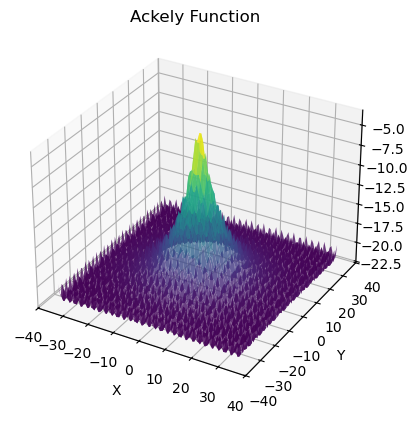

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-35, 35, 100)
y_range = np.linspace(-35, 35, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ackely Function')

# Show the plot
plt.show()

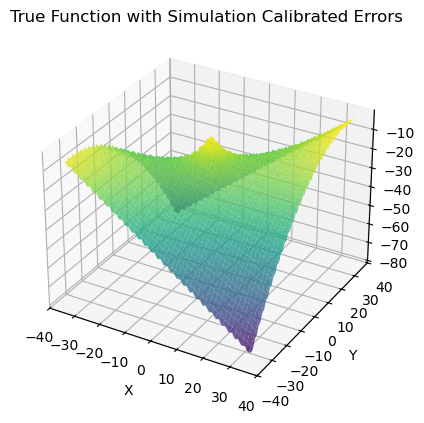

In [76]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [77]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [78]:
df_new = pd.DataFrame

In [79]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-35, 35, 100)
    x2_range = np.linspace(-35, 35, 100)
    bounds = np.array([[-35, 35], [-35, 35]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()


    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    return df, df2


Best hyperparameters:
num_layers: 2
num_units: 134
learning_rate: 0.06291137871314653
dropout_rate: 0.3977629344458919
batch_size: 146
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step - loss: 484.0456
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 318.2442
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 15.0559
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 629.2469
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 57.5131
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 37.3675
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 157.6853
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 175.1722
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 210.1757
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 141.9630
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 81.8762
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 34.0257
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

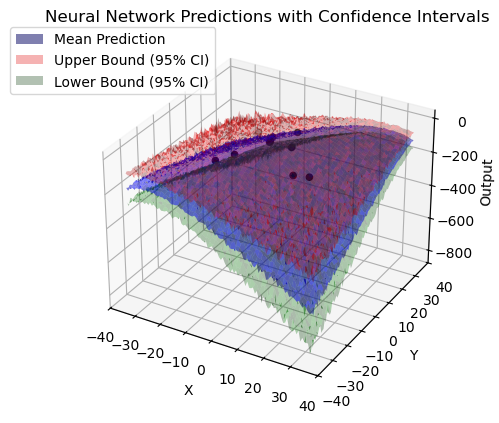

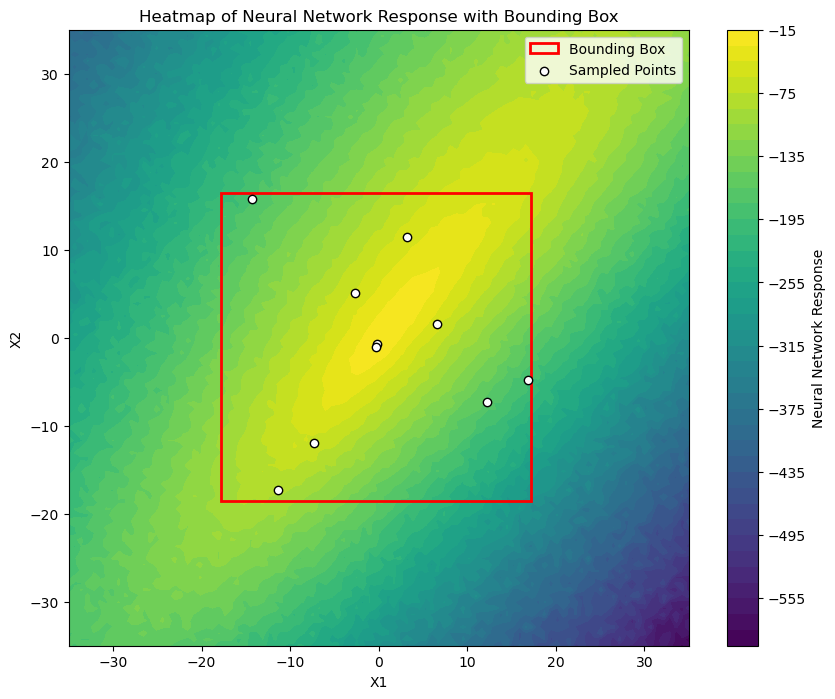

          x          y          z         a         b      sim_z      diff
1 -0.214261  -0.722330  -3.724348  4.549468 -3.334733  -3.724215 -0.000134
9 -0.353535  -1.060606  -4.518029  4.549468 -3.334733  -4.488758 -0.029272
2 -2.664589   5.097864 -12.793129  4.549468 -3.334733 -13.669707  0.876578
5  6.557843   1.556610 -14.628468  4.549468 -3.334733 -13.983675 -0.644793
0 -7.263303 -11.999905 -18.426015  4.549468 -3.334733 -18.573941  0.147925
            x          y          z         a         b      sim_z       diff
0   23.543825  11.618400 -21.792907  4.549468 -3.334733 -14.563439  -7.229468
1   31.442859  -7.073008 -21.554335  4.549468 -3.334733 -27.311424   5.757089
2   -4.794645  12.618852 -18.978809  4.549468 -3.334733 -23.703511   4.724702
3    9.034730  18.506400 -20.764875  4.549468 -3.334733 -20.864196   0.099320
4    5.999539  15.517246 -19.723279  4.549468 -3.334733 -20.722403   0.999124
5   -7.263303 -11.999905 -18.426015  4.549468 -3.334733 -18.573941   0.147925
6   

In [80]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.0007322372987269141
dropout_rate: 0.0
batch_size: 150
epochs: 50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 405.2406
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 401.1893
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 397.5007
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 393.8244
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 389.9067
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 385.5500
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 380.5738
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 374.7543
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 367.9665
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 360.1066
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 350.9979
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 340.4973
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 328.4632
Epoch 1

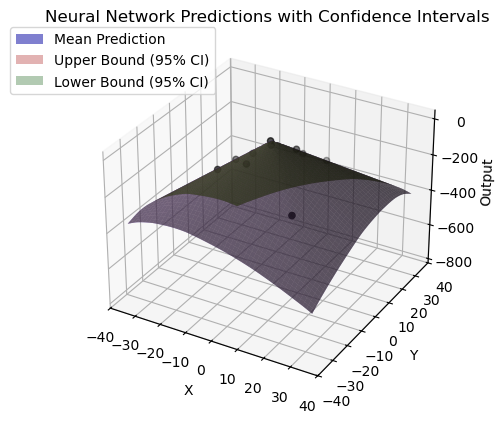

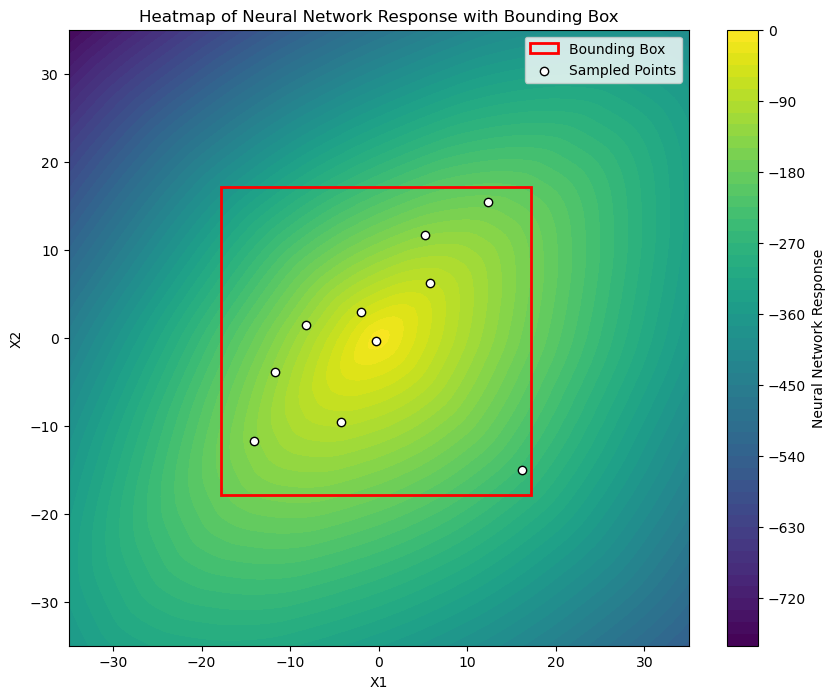

In [81]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.003338551299185723
dropout_rate: 0.0
batch_size: 20
epochs: 183
Epoch 1/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 375.0089
Epoch 2/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 367.8728 
Epoch 3/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 358.4595 
Epoch 4/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 329.3080 
Epoch 5/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 269.8299 
Epoch 6/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 159.3033 
Epoch 7/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.1382 
Epoch 8/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 182.9054 
Epoch 9/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.4187 
Epoch 10/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.7922 
Epoch 11/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73.5142 
Epoch 12/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.4091 
Epoch 13/183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.0720 


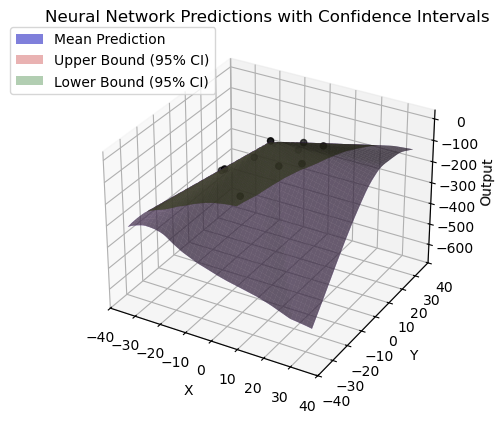

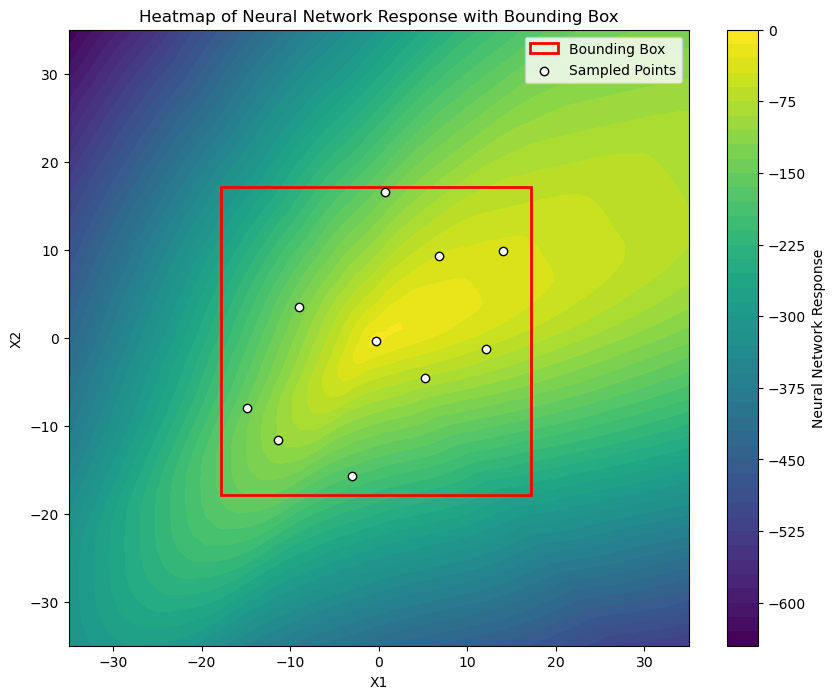

In [82]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 7
num_units: 50
learning_rate: 0.009790547581733115
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 352.6251
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 338.3412
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 304.6438
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 229.8443
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 100.5569
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 51.4112
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 82.6602
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 18.4956
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 30.7810
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 47.1937
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 44.4593
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.9935
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 16.8499
Epo

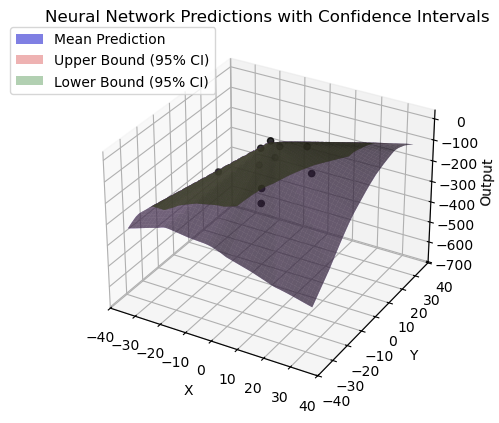

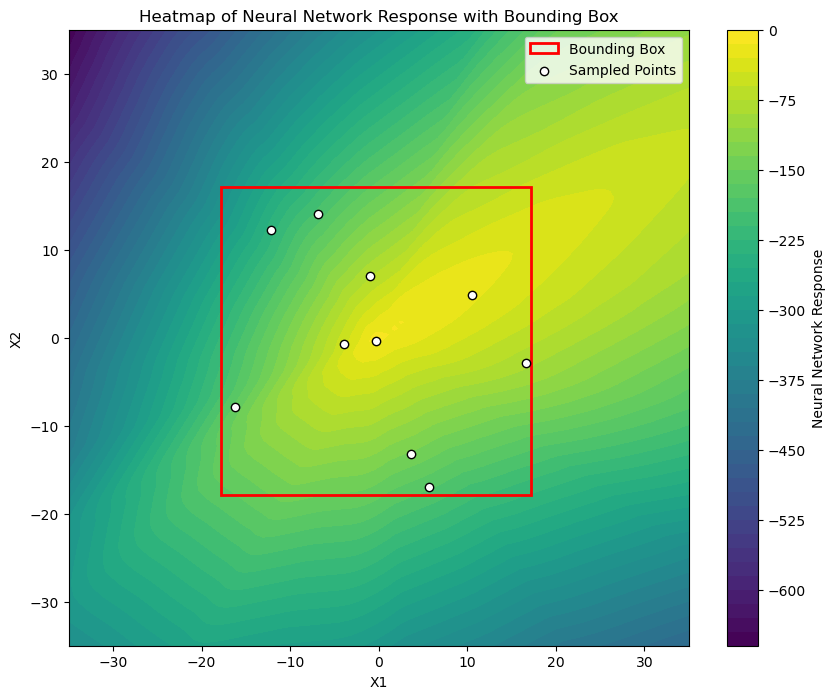

In [83]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.019553555319059175
dropout_rate: 0.22489446068954475
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step - loss: 359.6244
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 283.5851
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 177.2082
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 59.0101
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.1837
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 117.8079
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 74.9771
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.3918
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 18.0380
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 34.6958
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 50.6146
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 54.4100
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 

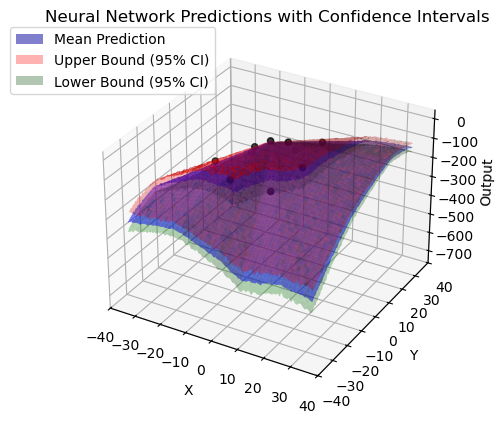

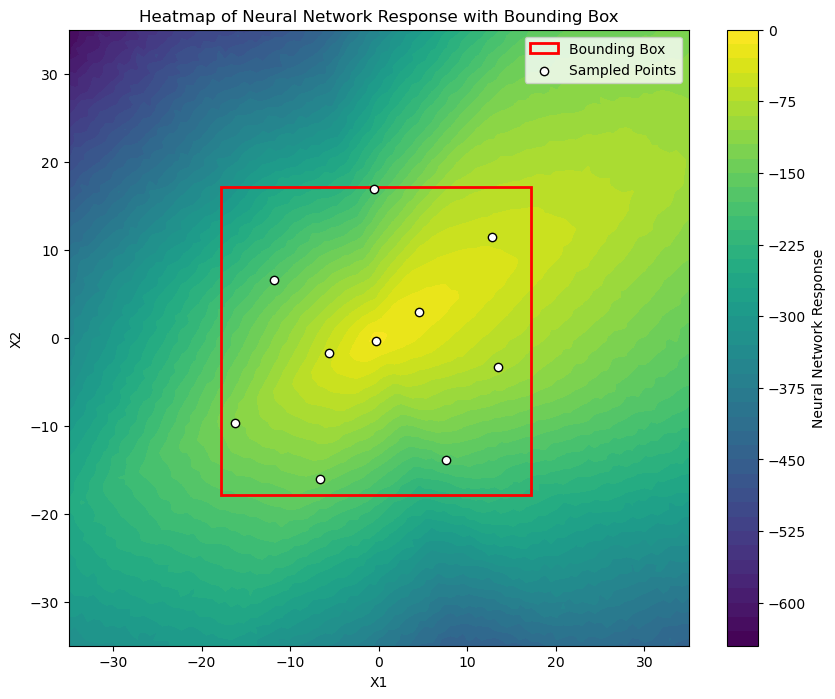

In [84]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 278.9476  
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 215.4824 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153.4447 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144.1149 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.1922  
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108.5456 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.3385 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47.9405 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.5829 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.3525 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.1003 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.7287 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.8708 
Epoch 14/200
3/3

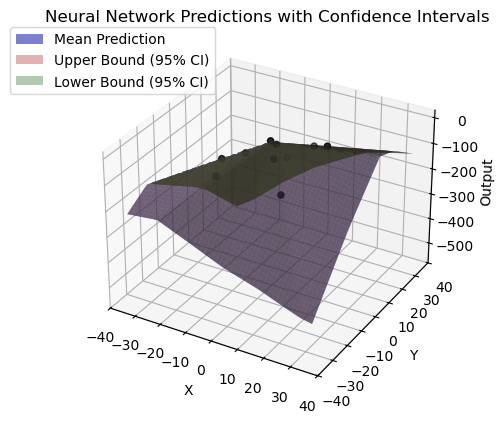

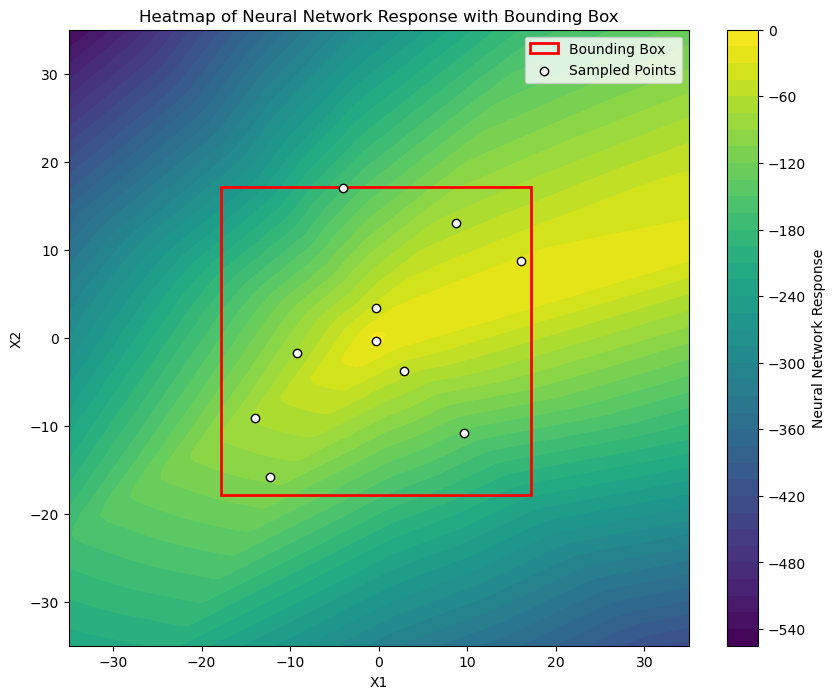

           x         y          z         a         b      sim_z      diff
9  -0.353535 -0.353535  -3.509969  4.549468 -3.334733  -3.567525  0.057556
8  -0.244120  3.415875  -9.701527  4.549468 -3.334733  -9.979998  0.278472
3   2.829279 -3.789788 -11.100248  4.549468 -3.334733 -11.453685  0.353436
5  16.100972  8.769773 -19.594584  4.549468 -3.334733 -15.809067 -3.785517
6  -9.218904 -1.680703 -16.535475  4.549468 -3.334733 -16.611986  0.076511
            x          y          z         a         b      sim_z      diff
0   23.543825  11.618400 -21.792907  4.549468 -3.334733 -14.563439 -7.229468
1   31.442859  -7.073008 -21.554335  4.549468 -3.334733 -27.311424  5.757089
2   -4.794645  12.618852 -18.978809  4.549468 -3.334733 -23.703511  4.724702
3    9.034730  18.506400 -20.764875  4.549468 -3.334733 -20.864196  0.099320
4    5.999539  15.517246 -19.723279  4.549468 -3.334733 -20.722403  0.999124
..        ...        ...        ...       ...       ...        ...       ...
60  16.1009

In [85]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 4
num_units: 50
learning_rate: 0.043685814793862444
dropout_rate: 0.0
batch_size: 69
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 347.9495
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 214.8477
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 71.0088
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 22.2950
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 30.1781
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 37.8738
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 19.1356
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12.3825
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 16.9801
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15.5467
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 14.1941
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13.6966
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 11.1576
Epoch 1

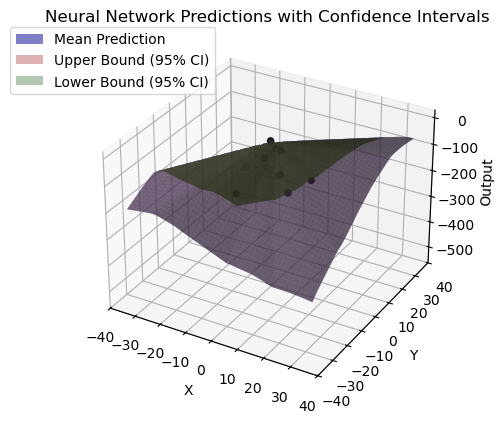

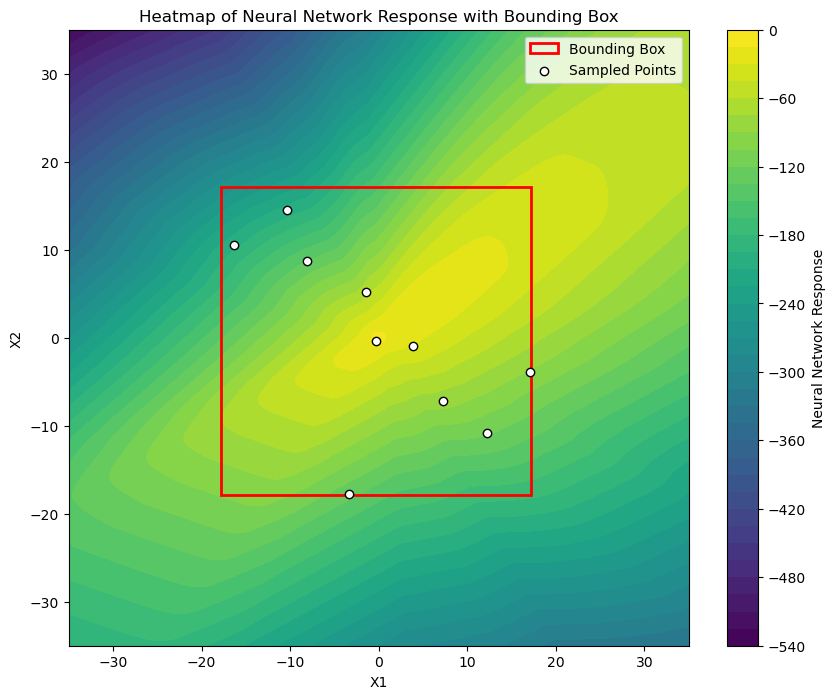

           x         y          z         a         b      sim_z      diff
9  -0.353535 -0.353535  -3.651918  4.549468 -3.334733  -3.553482 -0.098436
2   3.848584 -0.984131  -9.145339  4.549468 -3.334733  -9.032161 -0.113179
5  -1.455913  5.240717 -12.707889  4.549468 -3.334733 -13.580729  0.872841
4   7.210342 -7.168751 -16.383271  4.549468 -3.334733 -18.538025  2.154754
1  17.057663 -3.899303 -18.589309  4.549468 -3.334733 -19.956002  1.366693


In [86]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

In [87]:
df_new

x         y          z         a         b      sim_z      diff
9  -0.353535 -0.353535  -3.651918  4.549468 -3.334733  -3.553482 -0.098436
2   3.848584 -0.984131  -9.145339  4.549468 -3.334733  -9.032161 -0.113179
5  -1.455913  5.240717 -12.707889  4.549468 -3.334733 -13.580729  0.872841
4   7.210342 -7.168751 -16.383271  4.549468 -3.334733 -18.538025  2.154754
1  17.057663 -3.899303 -18.589309  4.549468 -3.334733 -19.956002  1.366693

In [88]:
df

x          y          z         a         b      sim_z      diff
0  23.543825  11.618400 -21.792907  4.549468 -3.334733 -14.563439 -7.229468
1  31.442859  -7.073008 -21.554335  4.549468 -3.334733 -27.311424  5.757089
2  -4.794645  12.618852 -18.978809  4.549468 -3.334733 -23.703511  4.724702
3   9.034730  18.506400 -20.764875  4.549468 -3.334733 -20.864196  0.099320
4   5.999539  15.517246 -19.723279  4.549468 -3.334733 -20.722403  0.999124

In [89]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: 0.8701534893654163


In [90]:
df = pd.concat([df, df_new], ignore_index=True)
df

x          y          z         a         b      sim_z      diff
0  23.543825  11.618400 -21.792907  4.549468 -3.334733 -14.563439 -7.229468
1  31.442859  -7.073008 -21.554335  4.549468 -3.334733 -27.311424  5.757089
2  -4.794645  12.618852 -18.978809  4.549468 -3.334733 -23.703511  4.724702
3   9.034730  18.506400 -20.764875  4.549468 -3.334733 -20.864196  0.099320
4   5.999539  15.517246 -19.723279  4.549468 -3.334733 -20.722403  0.999124
5  -0.353535  -0.353535  -3.651918  4.549468 -3.334733  -3.553482 -0.098436
6   3.848584  -0.984131  -9.145339  4.549468 -3.334733  -9.032161 -0.113179
7  -1.455913   5.240717 -12.707889  4.549468 -3.334733 -13.580729  0.872841
8   7.210342  -7.168751 -16.383271  4.549468 -3.334733 -18.538025  2.154754
9  17.057663  -3.899303 -18.589309  4.549468 -3.334733 -19.956002  1.366693

In [91]:
df = df.iloc[:, :-4]
df

x          y          z
0  23.543825  11.618400 -21.792907
1  31.442859  -7.073008 -21.554335
2  -4.794645  12.618852 -18.978809
3   9.034730  18.506400 -20.764875
4   5.999539  15.517246 -19.723279
5  -0.353535  -0.353535  -3.651918
6   3.848584  -0.984131  -9.145339
7  -1.455913   5.240717 -12.707889
8   7.210342  -7.168751 -16.383271
9  17.057663  -3.899303 -18.589309

In [92]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 4.55851322 -3.30843177]


In [93]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": -0.025, "Y":  -0.025, "Z": benchmark( -0.025,  -0.025)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y         Z
0 -0.025 -0.025 -0.133012

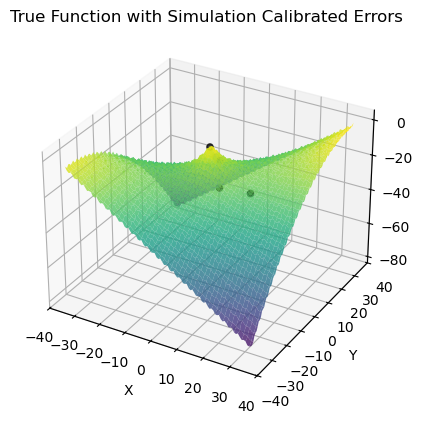

In [94]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [95]:
df

x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674
5  -0.353535  -0.353535  -3.651918  4.558513 -3.308432   -3.141865   -0.510053
6   3.848584  -0.984131  -9.145339  4.558513 -3.308432  -11.776886    2.631546
7  -1.455913   5.240717 -12.707889  4.558513 -3.308432    3.627408  -16.335296
8   7.210342  -7.168751 -16.383271  4.558513 -3.308432    5.014839  -21.398110
9  17.057663  -3.899303 -18.589309  4.558513 -3.308432  -25.910678    7.321368

In [96]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -50.49284634100758


In [97]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

           x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674


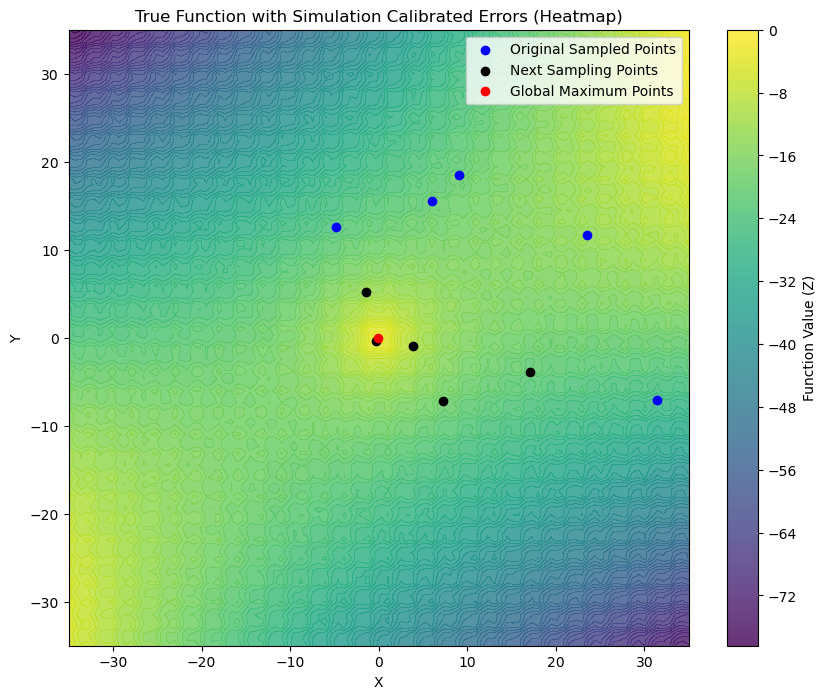

In [98]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [99]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 7
num_units: 199
learning_rate: 0.0021252073916553185
dropout_rate: 0.20718429411318445
batch_size: 82
epochs: 144
Epoch 1/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5052.8608
Epoch 2/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5045.0698
Epoch 3/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5028.2314
Epoch 4/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4997.1289
Epoch 5/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4943.0234
Epoch 6/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4837.4199
Epoch 7/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4634.3813
Epoch 8/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4347.5757
Epoch 9/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4080.1655
Epoch 10/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3108.0149
Epoch 11/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2178.8608
Epoch 12/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1392.3809
Epoch 13/144
1/1 ━━━━━━━━━━━━━━━━━

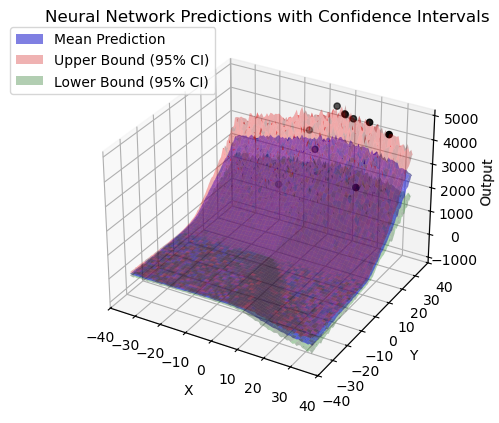

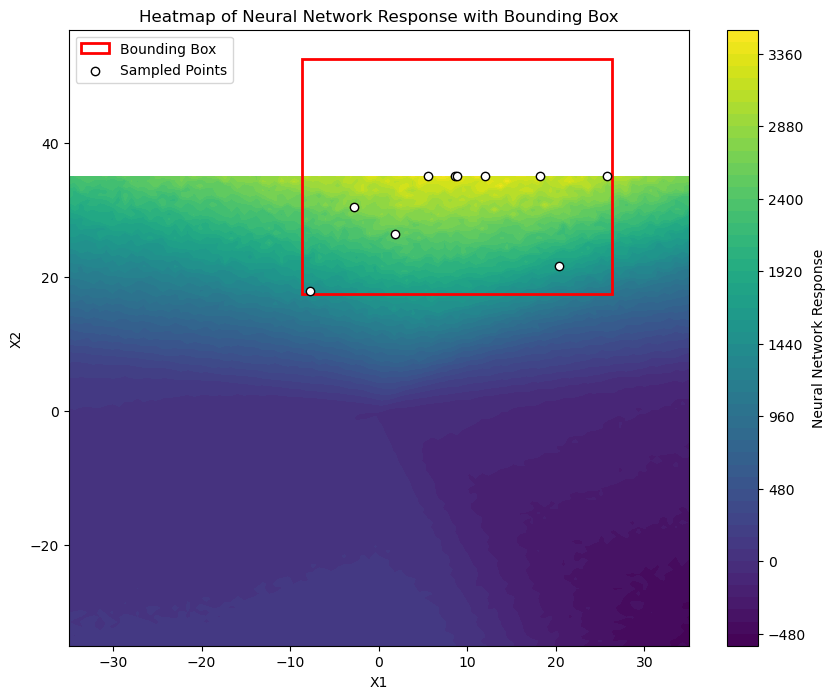

In [100]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 7
num_units: 192
learning_rate: 0.010258971685277325
dropout_rate: 0.2409351195059757
batch_size: 76
epochs: 165
Epoch 1/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2916.1147
Epoch 2/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2905.6243
Epoch 3/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2818.6389
Epoch 4/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3207.9243
Epoch 5/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2780.6448
Epoch 6/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2882.0640
Epoch 7/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2897.8840
Epoch 8/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2898.9771
Epoch 9/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2903.2146
Epoch 10/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2891.9016
Epoch 11/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2880.6267
Epoch 12/165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2845.1023
Epoch 13/165
1/1 ━━━━━━━━━━━━━━━━━━━

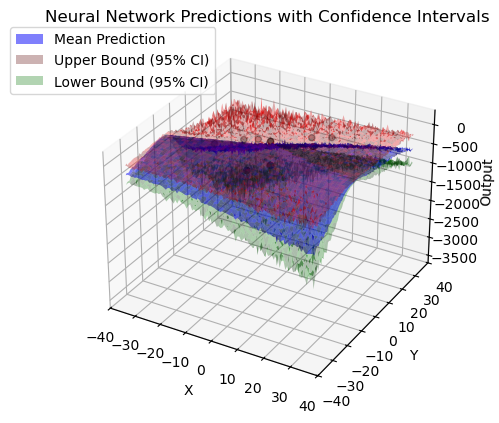

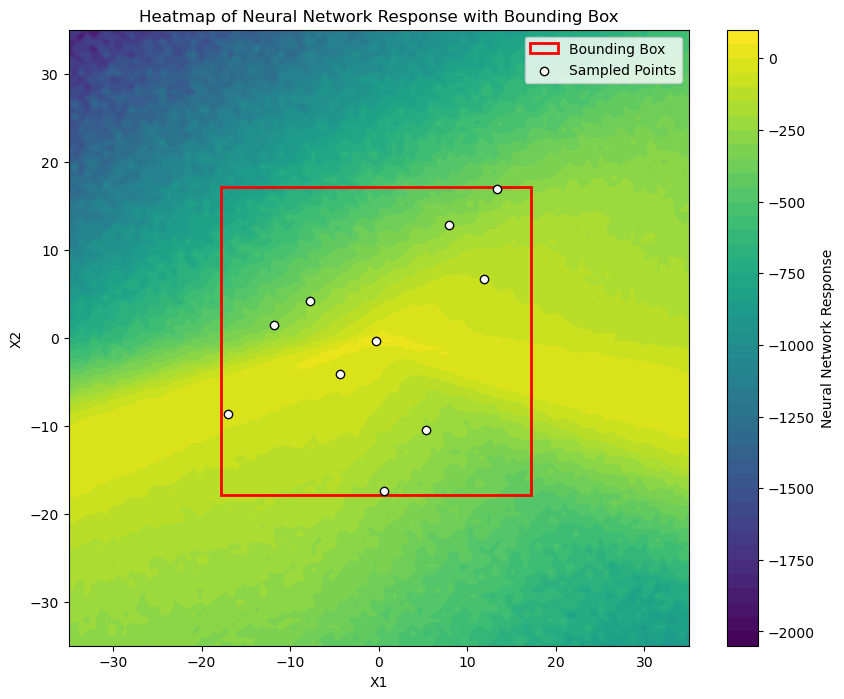

In [101]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 185
learning_rate: 0.0008342844054611701
dropout_rate: 0.0
batch_size: 88
epochs: 123
Epoch 1/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2058.4551
Epoch 2/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2057.7993
Epoch 3/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2057.1174
Epoch 4/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2056.1104
Epoch 5/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2054.6462
Epoch 6/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2052.4150
Epoch 7/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2048.9988
Epoch 8/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2043.8356
Epoch 9/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2036.1985
Epoch 10/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2025.0793
Epoch 11/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2009.3323
Epoch 12/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1988.0437
Epoch 13/123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

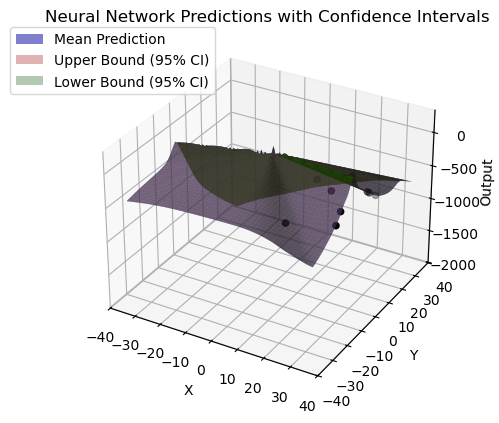

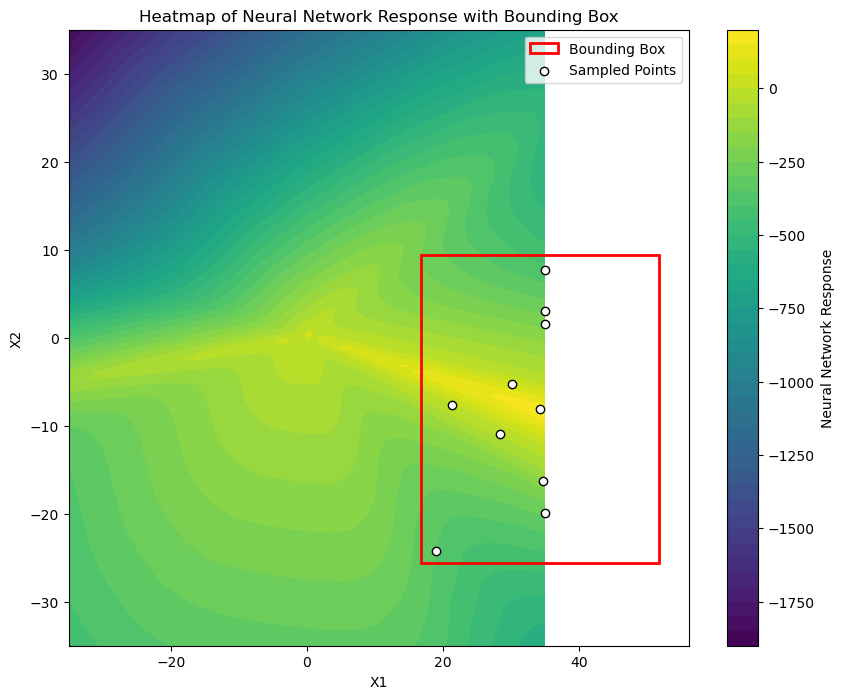

In [102]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 188
learning_rate: 0.0011756282070800373
dropout_rate: 0.2558774793979888
batch_size: 43
epochs: 153
Epoch 1/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1775.8953
Epoch 2/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1774.1877
Epoch 3/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1770.5494
Epoch 4/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1764.2317
Epoch 5/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1755.5863
Epoch 6/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1741.9856
Epoch 7/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1718.3386
Epoch 8/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1698.1791
Epoch 9/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1626.8801
Epoch 10/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1575.0958
Epoch 11/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1534.6083
Epoch 12/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1534.3031
Epoch 13/153
1/1 ━━━━━━━━━━━━━━━━━━

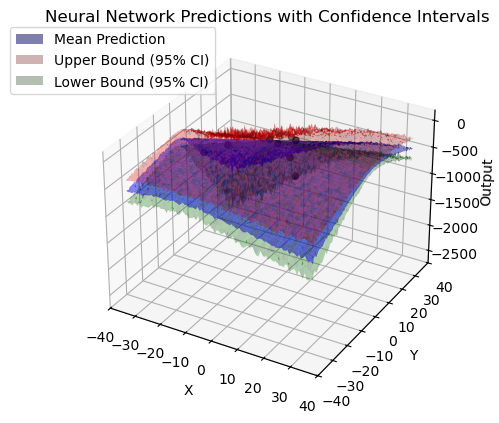

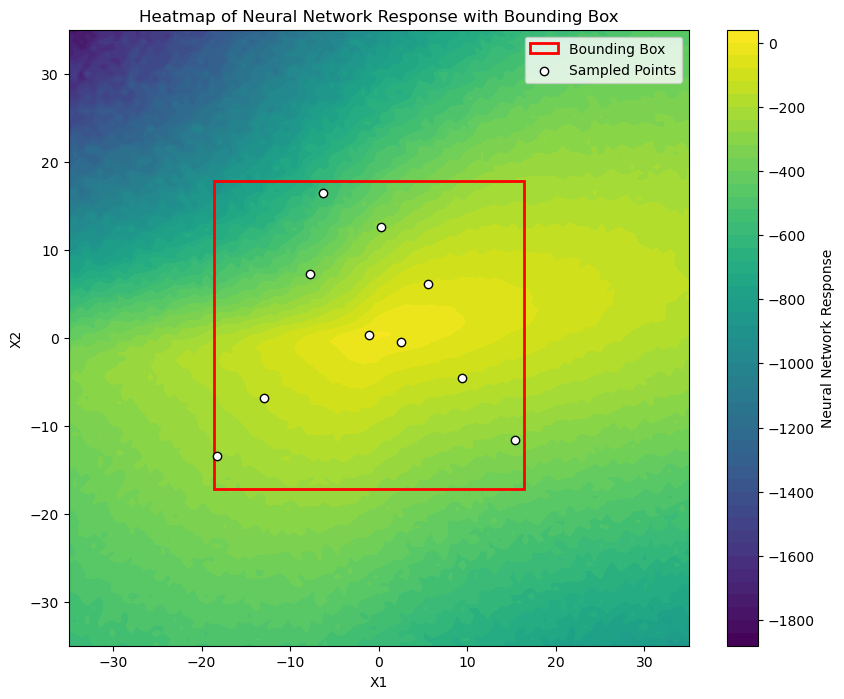

In [103]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.002127459439380763
dropout_rate: 0.35975665982909943
batch_size: 145
epochs: 88
Epoch 1/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1496.7007
Epoch 2/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1492.4194
Epoch 3/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1487.7473
Epoch 4/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1475.6921
Epoch 5/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1452.1678
Epoch 6/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1421.9442
Epoch 7/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1363.0142
Epoch 8/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1273.7080
Epoch 9/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1262.2196
Epoch 10/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1263.5988
Epoch 11/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1274.9901
Epoch 12/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1232.5935
Epoch 13/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

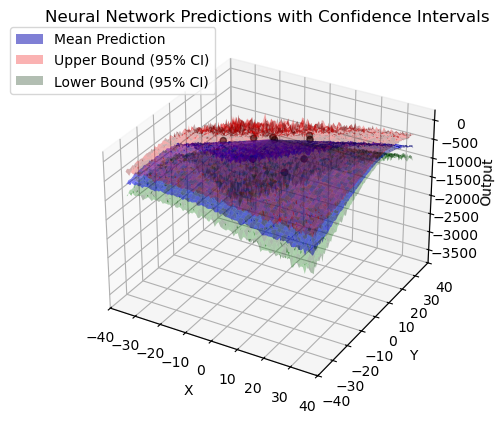

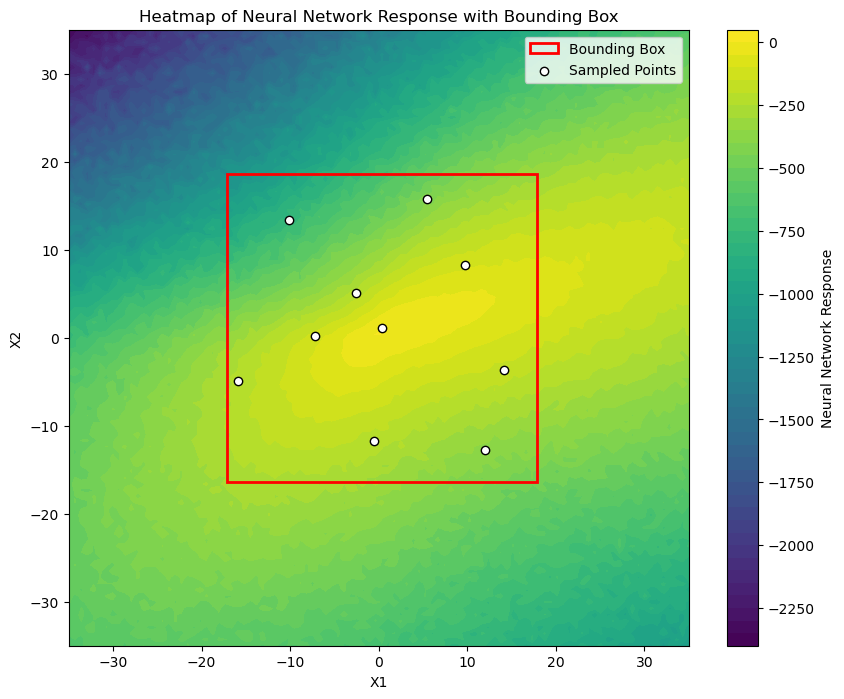

In [104]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 113
learning_rate: 0.0016774857410477234
dropout_rate: 0.12183292882148969
batch_size: 81
epochs: 112
Epoch 1/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1305.3032
Epoch 2/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1303.3003
Epoch 3/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1300.4738
Epoch 4/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1295.0715
Epoch 5/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1286.0093
Epoch 6/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1273.0836
Epoch 7/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1252.8503
Epoch 8/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1223.4102
Epoch 9/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1180.1389
Epoch 10/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1130.0618
Epoch 11/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1077.2655
Epoch 12/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1064.6096
Epoch 13/112
1/1 ━━━━━━━━━━━━━━━━━

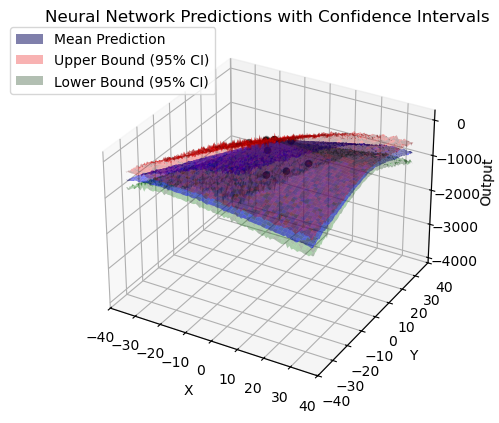

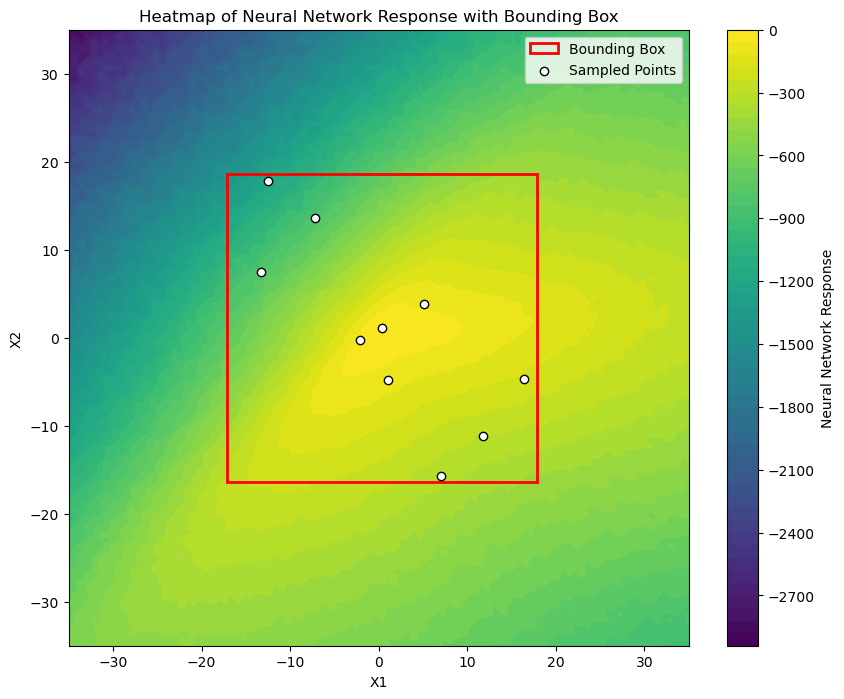

In [105]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 6
num_units: 94
learning_rate: 0.0014164288244163672
dropout_rate: 0.10183285011643646
batch_size: 39
epochs: 187
Epoch 1/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1000.9672
Epoch 2/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1215.2811 
Epoch 3/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1050.6348
Epoch 4/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1322.1792 
Epoch 5/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1054.6564
Epoch 6/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1310.7163 
Epoch 7/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1238.3082 
Epoch 8/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 908.8893 
Epoch 9/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1200.0381 
Epoch 10/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1029.8772 
Epoch 11/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1099.7334 
Epoch 12/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 894.6170 
Epoch 13/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 

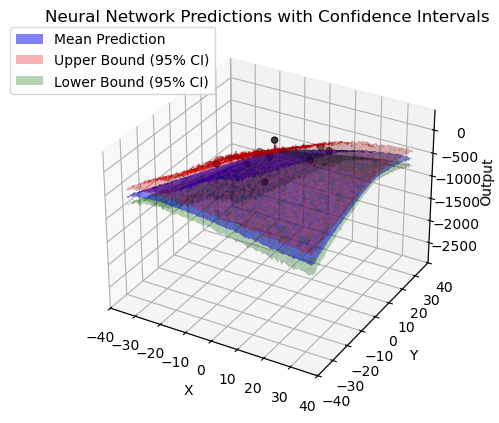

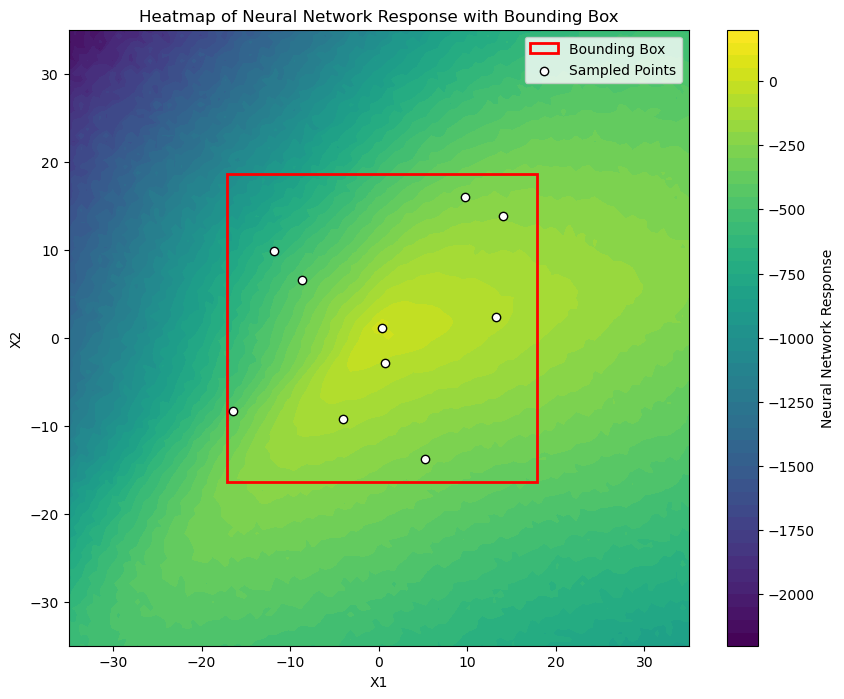

In [106]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [107]:
df_new2

x          y          z         a         b      sim_z      diff
9   0.353535   1.060606  -4.528937  4.558513 -3.308432  -4.423915 -0.105022
7   0.749010  -2.845675  -8.180547  4.558513 -3.308432  -8.320484  0.139937
3  14.004272  13.825317 -19.422100  4.558513 -3.308432 -15.737644 -3.684457
0  -4.040295  -9.269090 -16.430419  4.558513 -3.308432 -16.800240  0.369821
5  13.274854   2.299277 -18.989695  4.558513 -3.308432 -17.342310 -1.647385

In [108]:
df

x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674
5  -0.353535  -0.353535  -3.651918  4.558513 -3.308432   -3.141865   -0.510053
6   3.848584  -0.984131  -9.145339  4.558513 -3.308432  -11.776886    2.631546
7  -1.455913   5.240717 -12.707889  4.558513 -3.308432    3.627408  -16.335296
8   7.210342  -7.168751 -16.383271  4.558513 -3.308432    5.014839  -21.398110
9  17.057663  -3.899303 -18.589309  4.558513 -3.308432  -25.910678    7.321368

In [109]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x          y          z         a         b       sim_z  \
0   23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939   
1   31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804   
2   -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515   
3    9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668   
4    5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395   
5   -0.353535  -0.353535  -3.651918  4.558513 -3.308432   -3.141865   
6    3.848584  -0.984131  -9.145339  4.558513 -3.308432  -11.776886   
7   -1.455913   5.240717 -12.707889  4.558513 -3.308432    3.627408   
8    7.210342  -7.168751 -16.383271  4.558513 -3.308432    5.014839   
9   17.057663  -3.899303 -18.589309  4.558513 -3.308432  -25.910678   
10   0.353535   1.060606  -4.528937  4.558513 -3.308432   -4.423915   
11   0.749010  -2.845675  -8.180547  4.558513 -3.308432   -8.320484   
12  14.004272  13.825317 -19.422100  4.558513 -3.308432  -15.737644   
13  -4.040295  -9.269090 -16.430419  4.558513 -3.308432  -16.800240   
14  13.274854   2.299277 -18.989695  4.558513 -3.308432  -17.342310   

          diff  
0   -65.051846  
1     4.010469  
2   -91.728325  
3  -190.529543  
4  -133.338674  
5    -0.510053  
6     2.631546  
7   -16.335296  
8   -21.398110  
9     7.321368  
10   -0.105022  
11    0.139937  
12   -3.684457  
13    0.369821  
14   -1.647385

In [110]:
df = df.iloc[:, :-4]
df

x          y          z
0   23.543825  11.618400 -21.792907
1   31.442859  -7.073008 -21.554335
2   -4.794645  12.618852 -18.978809
3    9.034730  18.506400 -20.764875
4    5.999539  15.517246 -19.723279
5   -0.353535  -0.353535  -3.651918
6    3.848584  -0.984131  -9.145339
7   -1.455913   5.240717 -12.707889
8    7.210342  -7.168751 -16.383271
9   17.057663  -3.899303 -18.589309
10   0.353535   1.060606  -4.528937
11   0.749010  -2.845675  -8.180547
12  14.004272  13.825317 -19.422100
13  -4.040295  -9.269090 -16.430419
14  13.274854   2.299277 -18.989695

In [111]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.51043824 -3.31352674]


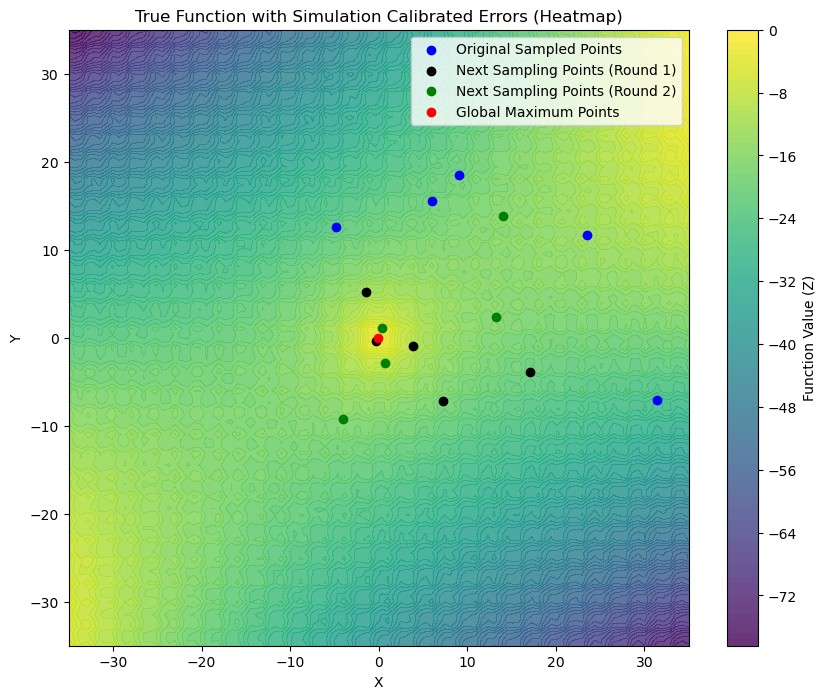

In [112]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [113]:
df_original

x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674

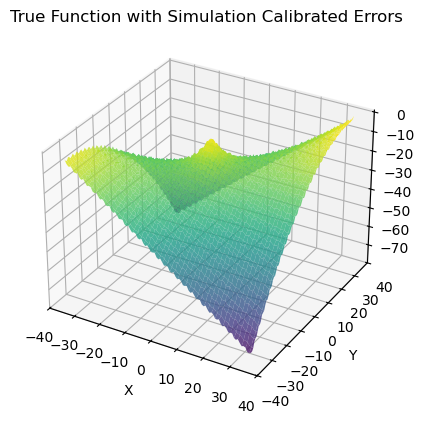

In [114]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()